In [ ]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.4 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import Levenshtein
import gc
from numba import njit
from sklearn.model_selection import train_test_split
# In newer TensorFlow versions, StringLookup is directly under keras.layers
from tensorflow.keras.layers import StringLookup # Changed import line
import datetime
from PIL import Image
# import cProfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
import cv2

def load_images_from_zip(zip_path):
    images = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for filename in zip_ref.namelist():
            # Check if the file is an image (you may need to adjust the condition)
            if filename.lower().endswith(('.png', '.jpg', '.jpeg','tif')):
                with zip_ref.open(filename) as img_file:
                    # Read image data and convert it to a NumPy array
                    img_data = img_file.read()
                    img = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_COLOR)

                    if img is not None:
                        images.append(img)
    return images

images = load_images_from_zip(r'/content/Total Images Processed.zip')

print(len(images))

15477


In [ ]:
# resize images to 32x32
resized_images = []
for img in images:
    img = cv2.resize(img, (64, 32))
    resized_images.append(img)

In [ ]:
import os
import zipfile

def load_labels_from_zip(zip_path):
    labels = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for filename in zip_ref.namelist():
            # Check if the file is a text file (you may need to adjust the condition)
            if filename.lower().endswith('.txt'):
                with zip_ref.open(filename) as label_file:
                    label = label_file.read().decode('utf-8')  # Decode bytes to string
                    labels.append(label)
    return labels

labels = load_labels_from_zip(r'/content/Total GT Processed.zip')
print(len(labels))

15477


## DEALING WITH LABELS

In [ ]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

labels_cleaned = clean_labels(labels)

In [ ]:
# select only the images with labels cleaned
resized_images = [img for img, label in zip(resized_images, labels_cleaned) if label]
labels = [label for label in labels_cleaned if label]

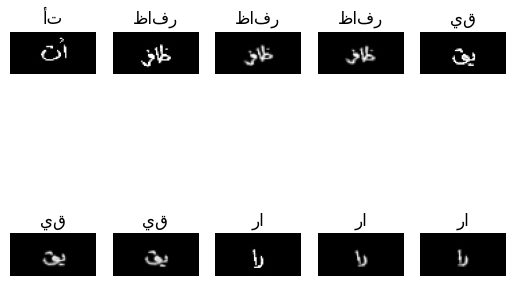

In [ ]:
#show first 10 images using plt with their repective decoded labels
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(resized_images[i], cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.show()

In [ ]:
# max_len = 0
# characters = set()
# for label in labels:
#     label = label.split(" ")[-1].strip()
#     for char in label:
#         characters.add(char)

#     max_len = max(max_len, len(label))

# print("Maximum length: ", max_len)
# print("Vocab size: ", len(characters))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

characters = {'ء','آ','أ','ؤ','إ','ئ','ا','ب','ة','ت','ث','ج','ح','خ','د','ذ','ر','ز','س','ش','ص','ض','ط','ظ','ع','غ','ف','ق','ك','ل','م','ن','ه','و','ى','ي'}
max_len = 7
# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=sorted(list(characters)), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [ ]:
print(len(characters))

36


In [ ]:
characters

{'ء',
 'آ',
 'أ',
 'ؤ',
 'إ',
 'ئ',
 'ا',
 'ب',
 'ة',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ف',
 'ق',
 'ك',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'ى',
 'ي'}

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# # Mapping characters to integers.
# char_to_num = StringLookup(vocabulary=sorted(list(characters)), mask_token=None)

# # Mapping integers back to original characters.
# num_to_char = StringLookup(
#     vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
# )

In [ ]:
padding_token = 99

In [ ]:
# Faster Vectorization (40s --> 0.8s)
def vectorize_label(label):
    # print(label)
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

labels_v = tf.data.Dataset.from_tensor_slices(labels) # Convert labels to a dataset
labels_v = labels_v.map(vectorize_label, num_parallel_calls=tf.data.AUTOTUNE) # Vectorize labels
labels_v = list(labels_v.as_numpy_iterator()) # Convert labels back to a list


In [ ]:
# Faster Devectorization (10s --> 0.3s)
@njit(cache=True)
def devectorize_label(label, vocabulary, padding_token):
    # Remove padding tokens
    label = label[label != padding_token]

    # Convert label indices back to characters
    characters = [vocabulary[idx] for idx in label]

    # Concatenate characters to form the original text
    original_text = ''.join(characters)

    return original_text

In [ ]:
vocab_num = np.array(char_to_num.get_vocabulary())

In [ ]:
vocab_num

array(['[UNK]', 'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث',
       'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ',
       'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي'],
      dtype='<U5')

In [ ]:
padding_token

99

In [ ]:
labels_de_v = [devectorize_label(label, vocab_num, padding_token) for label in labels_v]

## END

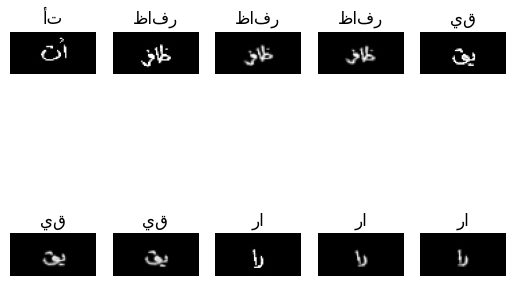

In [ ]:
#show first 10 images using plt with their repective decoded labels
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(resized_images[i], cmap='gray')
    plt.title(labels_de_v[i])
    plt.axis('off')
plt.show()

In [ ]:
print("length of labels: ",len(labels_de_v))
print("length of images",len(resized_images))
# if not equal, error
assert len(labels_de_v) == len(resized_images), "The number of labels does not match the number of images, check the loading process"

length of labels:  15372
length of images 15372


In [ ]:
# reshape data
resized_images = np.array(resized_images)
resized_images.shape

(15372, 32, 64, 3)

### Split

In [ ]:
# Normalize data
resized_images = resized_images / 255.0

In [ ]:
# First: split to train+val and test (keep test small)
X_temp, X_test, y_temp, y_test = train_test_split(resized_images, labels_v, test_size=0.1, random_state=42, stratify=labels_v)

# Then: split train into train and val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42, stratify=y_temp)
# 0.1111 * 0.9 ≈ 0.1 → So you get 80/10/10 split


In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

## LOSS

In [ ]:
import keras
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

    def get_config(self):
        config = super().get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [ ]:
from tensorflow.keras.callbacks import Callback
# Custom callback for calculating CER after each epoch
class CalculateCER(Callback):
    def __init__(self, validation_images, validation_labels):
        super(CalculateCER, self).__init__()
        self.validation_images = validation_images
        self.validation_labels = validation_labels
        self.cer_history = []

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.validation_labels  # True labels
        y_pred = self.model.predict([self.validation_images, np.zeros_like(self.validation_labels)])  # Predicted labels
        y_true_text = [devectorize_label(label,vocab_num, padding_token) for label in y_true]
        y_pred_text = decode_batch_predictions(y_pred)
        # print(f'Predicted text: {y_pred_text}')
        # print(f'True text: {y_true_text}')
        cer = self.calculate_cer(y_true_text, y_pred_text)
        self.cer_history.append(cer)
        print(f'\nCharacter Error Rate (CER) after epoch {epoch + 1}: {cer}')

    def calculate_cer(self, y_true, y_pred):
        total_distance = 0
        total_true_char = 0
        for true_seq, pred_seq in zip(y_true, y_pred):
            true_seq = true_seq.rstrip('\n')
            pred_seq = pred_seq.rstrip('\n')
            total_distance += Levenshtein.distance(true_seq, pred_seq)
            total_true_char += len(true_seq)
        cer = total_distance / total_true_char
        return cer


In [ ]:
# remove not needed images variable from memory and garbage collect
del images
gc.collect()

17230

## Pre-Trained ResNet50V2 Alphabetical

In [ ]:
import keras

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        # Use tf.keras.backend.ctc_batch_cost directly
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

    def get_config(self):
        config = super().get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
#load model
model = keras.models.load_model("/content/drive/MyDrive/Paper_Resnet512-WP-f.h5", custom_objects={"CTCLayer": CTCLayer})
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07))

In [ ]:
# # learning rate scheduler
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

cer = CalculateCER(X_test, y_test)

In [ ]:
# Define the learning rate scheduler
total_epochs = 70
def cosine_decay(epoch, lr):
    max_lr = 0.001  # Maximum learning rate
    min_lr = 0.00001  # Minimum learning rate
    step_size = total_epochs // 2  # Number of epochs for half of the cosine cycle
    decayed_lr = min_lr + 0.5 * (max_lr - min_lr) * (1 + tf.math.cos((epoch % step_size) / step_size * 3.1415))
    return decayed_lr

lr_scheduler = keras.callbacks.LearningRateScheduler(cosine_decay)

In [ ]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# set Random seed
tf.random.set_seed(42)

In [ ]:
# Define the learning rate scheduler
total_epochs = 30
def cosine_decay(epoch, lr):
    max_lr = 0.001  # Maximum learning rate
    min_lr = 0.00001  # Minimum learning rate
    step_size = total_epochs // 2  # Number of epochs for half of the cosine cycle
    # Convert the result of tf.math.cos to a NumPy float using .numpy()
    decayed_lr = min_lr + 0.5 * (max_lr - min_lr) * (1 + tf.math.cos((epoch % step_size) / step_size * 3.1415).numpy())
    return decayed_lr

lr_scheduler = keras.callbacks.LearningRateScheduler(cosine_decay)

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    # Changed keras.backend.ctc_decode to tf.keras.backend.ctc_decode
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [ ]:
# Train the model
history = model.fit(
    [X_train, y_train],
    epochs=total_epochs,
    validation_data=([X_test, y_test], y_test),
    batch_size=128,
    callbacks=[lr_scheduler, cer]
)

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step

Character Error Rate (CER) after epoch 1: 1.9578872234118487
97/97 ━━━━━━━━━━━━━━━━━━━━ 139s 678ms/step - loss: 1317.8494 - val_loss: 3734.8391 - learning_rate: 1.0000e-03
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step

Character Error Rate (CER) after epoch 2: 1.2543421365691172
97/97 ━━━━━━━━━━━━━━━━━━━━ 48s 495ms/step - loss: 713.5354 - val_loss: 2424.5415 - learning_rate: 9.8918e-04
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step

Character Error Rate (CER) after epoch 3: 0.702355460385439
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 492ms/step - loss: 555.5346 - val_loss: 1028.9667 - learning_rate: 9.5721e-04
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step

Character Error Rate (CER) after epoch 4: 0.6621460861289555
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 488ms/step - loss: 407.8492 - val_loss: 951.2690 - learning_rate: 9.0547e-04
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step

Character Error Rate (CER) after epoch 5: 0.38591482274565

In [ ]:
# Save the trained model
model.save("resnet50v2_trained_model.h5")

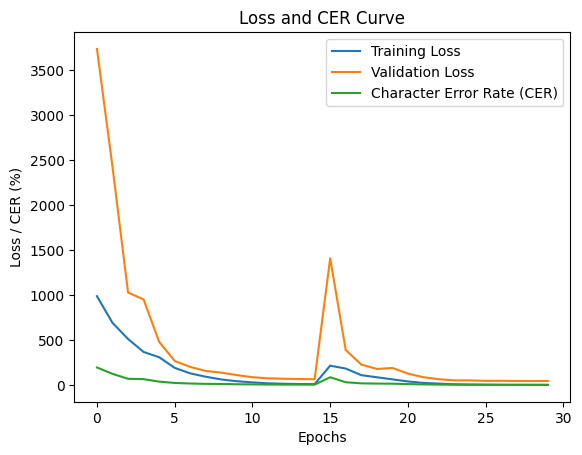

In [ ]:
# Plot the loss curve and CER curve
# normlize to 100%
cer_plot=[]
for value in cer.cer_history:
    value = value * 100
    cer_plot.append(value)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(cer_plot, label='Character Error Rate (CER)')
plt.xlabel('Epochs')
plt.ylabel('Loss / CER (%)')
plt.title('Loss and CER Curve')
plt.legend()
plt.show()

In [ ]:
model_without_CTC = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Save the model
model_without_CTC.save('Res50V2Alpha_without_CTC.h5')

In [ ]:
# from tensorflow.keras.models import load_model
# model_without_CTC = load_model('/content/drive/MyDrive/Res50V2Alpha_without_CTC.h5')

## Evaluation

In [ ]:
# Evaluate the model #Not needed for now
# model.evaluate([X_test, y_test])

In [ ]:
# predict
y_pred = model.predict([X_val, np.zeros_like(y_val)]) # predict without labels

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


In [ ]:
y_test.dtype

dtype('int64')

In [ ]:
y_test

array([[36, 99, 99, ..., 99, 99, 99],
       [27, 17, 99, ..., 99, 99, 99],
       [33, 99, 99, ..., 99, 99, 99],
       ...,
       [30, 14, 36, ...,  9, 99, 99],
       [19,  3, 30, ..., 99, 99, 99],
       [ 0, 99, 99, ..., 99, 99, 99]])

In [ ]:
y_test_empty = np.zeros_like(y_test)
y_test_empty

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y_test_empty[0]

array([0, 0, 0, 0, 0, 0, 0])

In [ ]:
y_test.shape

(1538, 7)

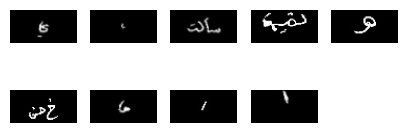

In [ ]:
# plot X_test 9 images
# plot X_test 9 images
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[-i], cmap='gray')
    plt.axis('off')
plt.show()

### CER Error

In [ ]:
y_pred_text = decode_batch_predictions(y_pred)

In [ ]:
# devectorize the labels
y_val_texts = [devectorize_label(label,vocab_num, padding_token) for label in y_val]

In [ ]:
# Get the current timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# Save y_pred_text as a whole txt file with timestamp
with open(f'y_pred_text_{timestamp}.txt', 'w', encoding='utf-8') as f:
    for item in y_pred_text:
        f.write("%s\n" % item)

# Save y_test_texts as a whole txt file with timestamp
with open(f'y_val_texts_{timestamp}.txt', 'w', encoding='utf-8') as f:
    for item in y_val_texts:
        f.write("%s\n" % item)

In [ ]:
def calculate_cer(y_true, y_pred):
    total_distance = 0
    total_true_char = 0
    for true_seq, pred_seq in zip(y_true, y_pred):
        true_seq = true_seq.rstrip('\n')
        pred_seq = pred_seq.rstrip('\n')
        total_distance += Levenshtein.distance(true_seq, pred_seq)
        total_true_char += len(true_seq)
    calc=[total_distance, total_true_char]
    cer = (total_distance / total_true_char)
    return cer, calc

cer, calc = calculate_cer(y_val_texts, y_pred_text)
print(calc[0],"/",calc[1],"=","{:.2f}%".format(cer*100))

104 / 4210 = 2.47%
